    Import Required Libraries

In [1]:
import os
import cv2
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from ultralytics import YOLO

# import mediapipe as mp
import time 

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [1]:
import torch

torch.cuda.is_available()



False

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("fuck")

fuck


Set Numpy, Python and Tensorflow seeds to a constant to get consistent results on every execution

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

dataset = "F:\CS3501-Data_Science_and_Engineering_Project\Project Files\Human-Action-Recognition-in-the-dark\datasets\clips_v1.5"

    1. Visualize the Dataset

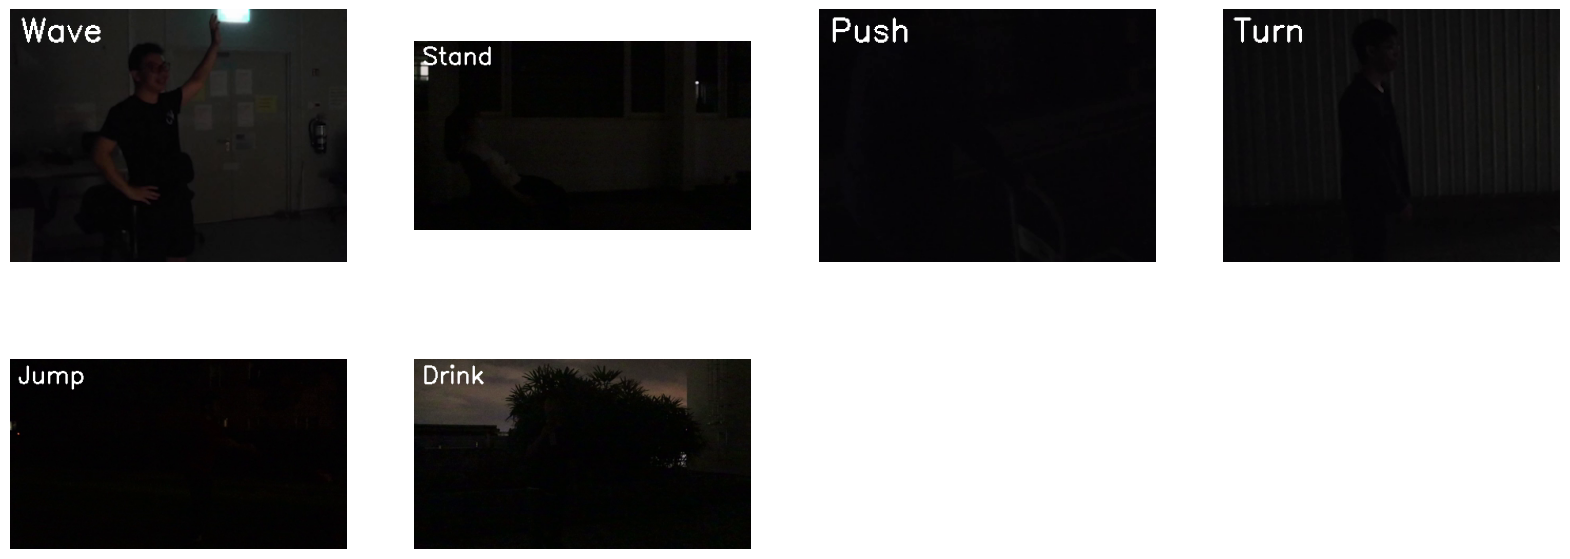

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(dataset)

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 6)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{dataset}/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{dataset}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);
    plt.imshow(rgb_frame);plt.axis('off')

    2. Preprocess the Dataset

        2.1. Initialize Constants

In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = dataset


# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = ["boxing", "handwaving", "running", "walking"]
CLASSES_LIST = ["Drink", "Jump", "Pour", "Run", "Sit", "Stand", "Walk", "Turn"]

In [6]:
print(len(CLASSES_LIST))

8


In [127]:
import cv2

# Load the image
image = cv2.imread('../runs/pose/predict/image3.jpg', 0)

# Apply Gamma Correction
equalized_image = cv2.equalizeHist(image)

# cv2.imwrite('brightened_image.jpg', brightened_image)

# Display the Original and Brightened Images
cv2.imshow('Original Image', image)
cv2.imshow('Brightened Image', equalized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [7]:
# import cv2

clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(16, 16))

def apply_clahe(frame):
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
    v = clahe.apply(v)
    hsv_img = np.dstack((h, s, v))
    frame = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
    return frame

In [8]:
from ultralytics import YOLO

pose_model = YOLO('yolov8n-pose.pt')


In [119]:
video_reader = cv2.VideoCapture("../Walk_1_8_2.avi")
frames_list = []
    
video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read() 

    if not success:
        break
    # frame = apply_clahe(frame)
    # resized_frame = cv2.resize(frame, (int(
    #         video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(
    #         video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))))
    # normalized_frame = resized_frame / 255
    frames_list.append(frame)

video_reader.release()
 



In [128]:
results = pose_model(equalized_image, save=True, show=True)
# results = pose_model("../runs\pose\predict\image15.jpg", save=True, stream = True)
# runs\pose\predict\image0.jpg

# import cv2
# from ultralytics import YOLO

# # Load the YOLOv8 model

# # Open the video file
# video_path = "../Walk_1_8_2.avi"
# cap = cv2.VideoCapture(video_path)

# # Loop through the video frames
# count = -1
# while cap.isOpened():
#     # Read a frame from the video
#     success, frame = cap.read()
#     count+=1

#     if success:
#         # Run YOLOv8 inference on the frame
#         if count % 3 == 0:
#             # frame = apply_clahe(frame)
#             results = pose_model.track(frame, persist=True, save=True)

#         # Visualize the results on the frame
#         annotated_frame = results[0].plot()

#         # Display the annotated frame

#         # Break the loop if 'q' is pressed
#         if cv2.waitKey(1) & 0xFF == ord("q"):
#             break
#     else:
#         # Break the loop if the end of the video is reached
#         break

# # Release the video capture object and close the display window
# cap.release()
# cv2.destroyAllWindows()


ValueError: axes don't match array

In [122]:
list(results)[0]


0: 480x640 (no detections), 1: 480x640 (no detections), 2: 480x640 (no detections), 3: 480x640 (no detections), 4: 480x640 1 person, 5: 480x640 1 person, 6: 480x640 1 person, 7: 480x640 1 person, 8: 480x640 1 person, 9: 480x640 1 person, 10: 480x640 1 person, 11: 480x640 1 person, 12: 480x640 1 person, 13: 480x640 1 person, 14: 480x640 1 person, 15: 480x640 1 person, 16: 480x640 3 persons, 17: 480x640 1 person, 18: 480x640 1 person, 19: 480x640 1 person, 1203.3ms
Speed: 2.9ms preprocess, 60.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to f:\CS3501-Data_Science_and_Engineering_Project\Project Files\Human-Action-Recognition-in-the-dark\runs\pose\predict


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: ultralytics.engine.results.Keypoints object
masks: None
names: {0: 'person'}
orig_img: array([[[ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6],
        ...,
        [13, 13, 13],
        [13, 13, 13],
        [13, 13, 13]],

       [[ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6],
        ...,
        [13, 13, 13],
        [13, 13, 13],
        [13, 13, 13]],

       [[ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6],
        ...,
        [13, 13, 13],
        [13, 13, 13],
        [13, 13, 13]],

       ...,

       [[ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 8,  5,  6],
        [ 8,  5,  6],
        [ 8,  5,  6]],

       [[ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 8,  5,  6],
        [ 8,  5,  6],
        [ 8,  5,  6]],

       [[ 4,  4,  4],
        [ 4,  4,  4],
   

In [46]:
for result in results:
    boxes = result.boxes # Boxes object for bbox outputs
    print(boxes.xywh)
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs
    break

tensor([], size=(0, 4))


In [83]:
boxes.xywh

tensor([], size=(0, 4))

In [123]:
cv2.destroyAllWindows()

        2.2. Define Function to Extract Frames from a Video

In [63]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
        frame = apply_clahe(frame)
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

        2.3. Define Function to Create Dataset

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list: # Iterate through all the files present in the files list.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: handclapping
Extracting Data of Class: handwaving
Extracting Data of Class: jogging
Extracting Data of Class: running


        2.4. Encode the Frames

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# Training and Prediction

        2.5. Split the Data Into Train and Test Sets

In [14]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

    3. Implement the LRCN Approach

        3.1. Construct the Model

In [11]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [12]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

        3.2. Check the Model Structure

In [13]:
# visualkeras.layered_view(LRCN_model).show() # display using your system viewer
# visualkeras.layered_view(LRCN_model, to_file='output.png') # write to disk
# visualkeras.layered_view(LRCN_model, to_file='output.png').show() # write and show

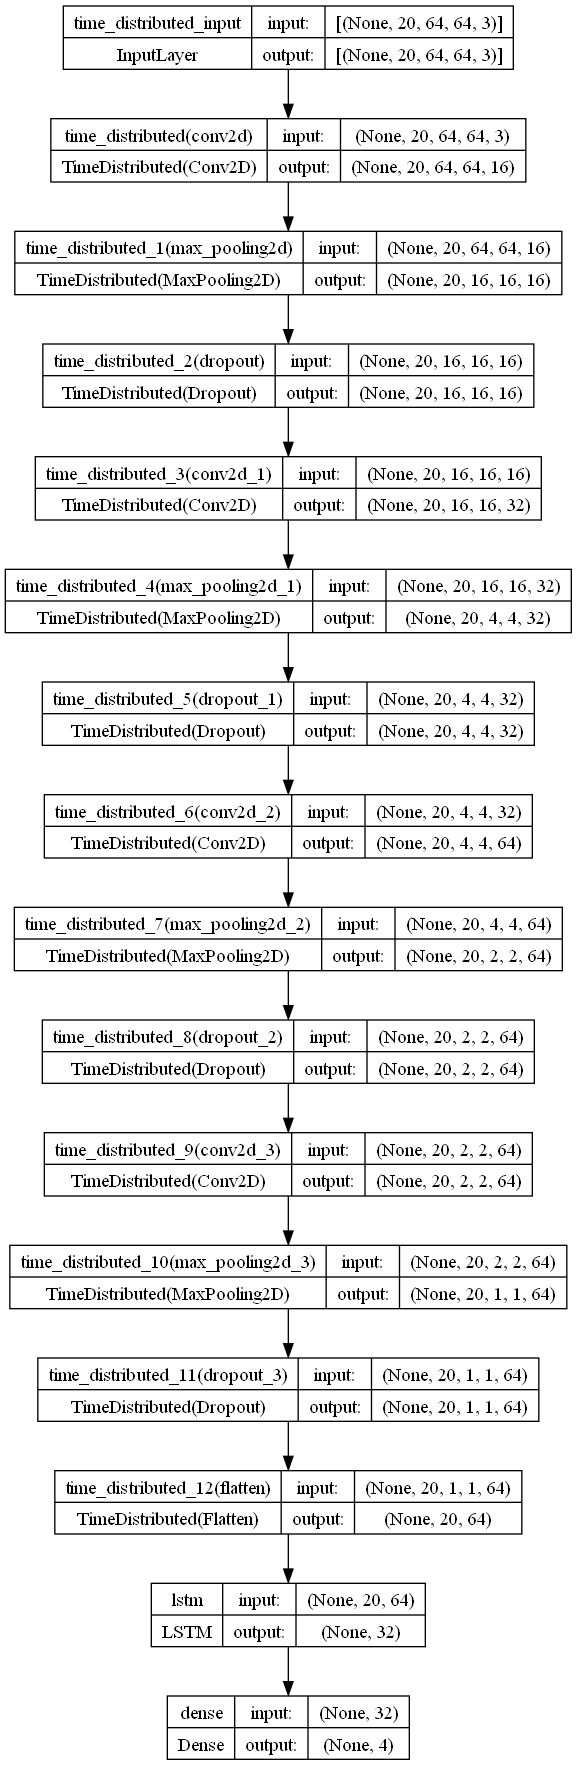

In [14]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

        3.3. Compile and Train the Model

In [15]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
60/60 [==============================] - 9s 100ms/step - loss: 1.4102 - accuracy: 0.2552 - val_loss: 1.3878 - val_accuracy: 0.2667
Epoch 2/70
60/60 [==============================] - 5s 91ms/step - loss: 1.3590 - accuracy: 0.3264 - val_loss: 1.2395 - val_accuracy: 0.4667
Epoch 3/70
60/60 [==============================] - 5s 88ms/step - loss: 0.9036 - accuracy: 0.4603 - val_loss: 0.7247 - val_accuracy: 0.5167
Epoch 4/70
60/60 [==============================] - 5s 90ms/step - loss: 0.7140 - accuracy: 0.5314 - val_loss: 0.7264 - val_accuracy: 0.4833
Epoch 5/70
60/60 [==============================] - 5s 88ms/step - loss: 0.7102 - accuracy: 0.5272 - val_loss: 0.7488 - val_accuracy: 0.5833
Epoch 6/70
60/60 [==============================] - 5s 84ms/step - loss: 0.7455 - accuracy: 0.5816 - val_loss: 0.6806 - val_accuracy: 0.6000
Epoch 7/70
60/60 [==============================] - 5s 82ms/step - loss: 0.7123 - accuracy: 0.5983 - val_loss: 0.6679 - val_accuracy: 0.6500
Epoch 8/70
6

        3.4. Evaluate the Trained Model

In [16]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 96ms/step - loss: 0.4382 - accuracy: 0.8300


In [17]:
# Get model predictions for the test dataset
predictions = LRCN_model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot-encoded predictions to class indices

# Calculate the confusion matrix
confusion_mat = confusion_matrix(np.argmax(labels_test, axis=1), predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

4/4 [==============================] - 1s 94ms/step
Confusion Matrix:
[[26  3  0  0]
 [ 7 16  0  0]
 [ 0  0 24  4]
 [ 0  0  3 17]]


        3.5. Save the Model

In [18]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'Models/LRCN_model_Date_Time_{current_date_time_string}_Loss_{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

c:\Users\ALI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


        3.6. Plot Model Evaluation Curves

In [19]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

            3.6.1. Loss Curves

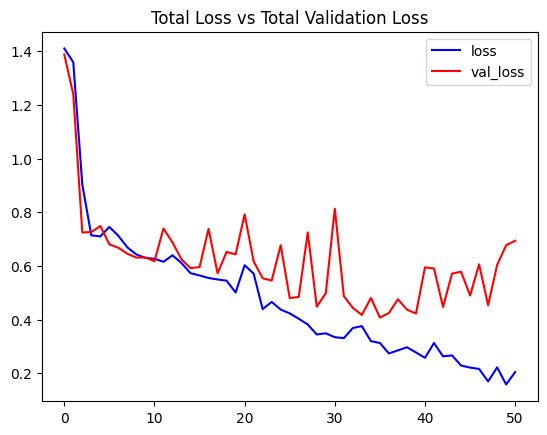

In [20]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

            3.6.2. Accuracy Curves

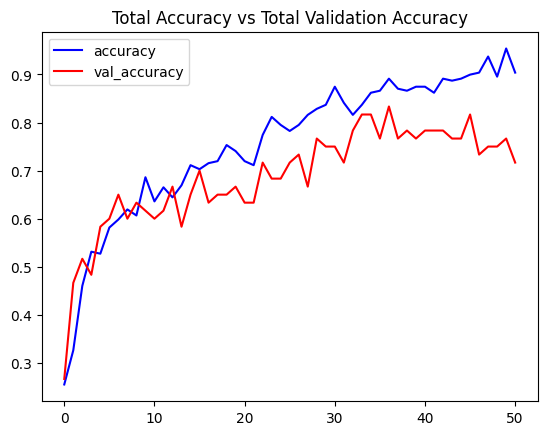

In [21]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')